# Virtual ADC example
---


## Load the bitstream into the Programmable Logic

In [1]:
%reload_ext autoreload
%autoreload 2
# Import the X-HEEP Python class
from pynq import x_heep

# Allow the import of all modules in this directory
import sys
SDK_PATH        = '/home/xilinx/x-heep-femu-sdk/sw/'        # Path to the SDK of the FEMU
RISCV_PATH      = 'riscv/'                                  # Path to the RISCV files
APP_PATH        = SDK_PATH + RISCV_PATH + 'apps/adc-emu/'   # Path to the .c file of the ADC-emu application
ADC_BIN_NAME    = 'adc_in'                                  # Name of the file that will be used as ADC input    
NB_PATH         = SDK_PATH + 'arm/apps/adc-emu/'            # Path to this notebook         

sys.path.append(SDK_PATH + "arm/sdk/")

from timeseries import *
from report import *

# Load the X-HEEP bitstream
xh = x_heep()

## Take a `.txt` and turn it into a `Timeseries` variable

In [2]:
import numpy as np
from timeseries import Timeseries

# Fixed information on where input and output data should be stored, and in which format
PATH_IN         = 'in/'
PATH_OUT        = 'out/'
EXTENSION_IN    = '.txt'
EXTENSION_OUT   = '.pkl'

In [3]:
# The file to be converted. 
# It should contain a single data point per line and nothing else. 
# No header information. 
FILENAME = 'Biopac'  
TIME_s  = 60

# Open the file and read the values
y = []
with open(NB_PATH + PATH_IN + FILENAME + EXTENSION_IN) as f:
    y = f.readlines()

# Parse the data into numbers
data = np.asarray([int(np.round(float(f))) for f in y])

# Compute the timing information based on the TIME_s variable set before
s_n = len(data)
T_s = TIME_s/s_n
f_Hz = s_n/TIME_s
time = np.arange(0,TIME_s,T_s)

# Create the timeseries variable and store it in the output path as a .pkl 
signal = Timeseries('Raw')
signal.data = data
signal.time = time
signal.dump( path = NB_PATH + PATH_OUT, name = FILENAME)

## Generate an input array to use as signal 

In [40]:
import numpy as np
from timeseries import Timeseries

MAX_POSSIBLE_DATA_LENGTH    = 2048
INPUT_DATA_LENGTH           = 800

# Load the data as a timeseries
din = Timeseries.load(NB_PATH + PATH_OUT + FILENAME + EXTENSION_OUT)

# Turn all values into unsigned by offsetting them
din.data  += abs(min(din.data))

# To abide by the memory constraint, downsample the signal
downsample = int(len(din.data)/INPUT_DATA_LENGTH)
din.data = din.data[INPUT_DATA_LENGTH::downsample]
din.time = din.time[INPUT_DATA_LENGTH::downsample]

# Export the binary file to the application folder
din.export_bin(path=APP_PATH, name=ADC_BIN_NAME)

INPUT_DATA_LENGTH = len(din.data)
print(f"Sent {INPUT_DATA_LENGTH} words as input")

Sent 800 words as input


## Compile the code and run the application
You can change the variable `SKIP_COMPILE`  to 1 to avoid compiling each time.

You can change the variable `SKIP_MEMORY`   to 1 to avoid generating the ADC memory each time.

You can change the variable `VERBOSE`       to 0 to supress the live printing of the UART.

In [41]:
# Skip compiling if all you want to do is run the application
# Note that the compilation is affected by the parameters written to the definitions.h file
SKIP_COMPILE    = 0
# Skip the memory generation
SKIP_MEMORY     = 0
# Wether to see the X-HEEP UART output live.
VERBOSE         = 0
# Enable the printfs inside X-HEEP application. 
# This is not the same as VERBOSE, as 
# a) it actually reflects in C-code and therefore in performance.
# b) Will not allow to read the output to plot in this notebook
ENABLE_PRINTF   = 1

# Define some standards to parse the X-HEEP output
OUTPUT_START_SEQ    = "# "
OUTPUT_DIVIDER      = "|"
OUTPUT_END_SEQ      = "#---"   

# Write the definitions header file to share information with the C code
defs = APP_PATH + 'definitions.h'
xh.open_definitions (defs, "DEFINITIONS")
xh.add_definition   (defs, "INPUT_DATA_LENGTH", INPUT_DATA_LENGTH)
xh.add_definition   (defs, "ENABLE_PRINTF",     ENABLE_PRINTF)
xh.add_definition   (defs, "OUTPUT_START_SEQ",  OUTPUT_START_SEQ)
xh.add_definition   (defs, "OUTPUT_DIVIDER",    OUTPUT_DIVIDER)
xh.add_definition   (defs, "OUTPUT_END_SEQ",    OUTPUT_END_SEQ)
xh.close_definitions (defs)

# Compile the application
if SKIP_COMPILE or xh.compile_app("adc-emu"):

    if not SKIP_MEMORY:
        # Write the ADC data to the virtual ADC
        adc = xh.init_adc_mem() # Init the ADC memory
        xh.reset_adc_mem(adc)   # Reset the ADC memory
        xh.write_adc_mem(adc)   # Write the ADC memory

    t, sf = xh.thread_start(VERBOSE)   # Start a background thread that reads from the UART

    perf_cnt = xh.init_perf_cnt()       # Init the performance counters
    xh.reset_perf_cnt(perf_cnt)         # Reset the performance counters
    xh.start_perf_cnt_manual(perf_cnt)  # Start the performance counters

    out, _ = xh.run_app()               # Run the application (disregarding the error output)

    xh.stop_perf_cnt(perf_cnt)          # Stop the performance counters

    xh.thread_stop(t, sf)               # Stop the background thread that reads from the UART

✅ Compile SUCCESS
✅ Return SUCCESS
 


### Parse the UART output

In [42]:
# Extract the UART output from X-HEEP
app_out = xh.uart_data

# Find positions of strings starting with "#"
starts = [i for i, s in enumerate(app_out) if s.startswith(OUTPUT_START_SEQ)]
# Find positions of strings starting with "#"
ends = [i for i, s in enumerate(app_out) if s.startswith(OUTPUT_END_SEQ)]

# Sanity check to make sure that all output lists are closed
if len(starts) != len(ends): sys.exit("❌ Invalid output")

# Will divide the outputs in a list of dictionaries containing headers and data
outs = []
for seq in range(len(starts)):
    s = starts[seq]
    e = ends[seq]
    # Strip the headers of the format markers
    headers = app_out[s].split(OUTPUT_DIVIDER)
    headers = [ h.strip().replace(OUTPUT_START_SEQ,'') for h in headers ]
    # Strip the data of the format markers and covert it into a numpy array of integers
    data  = [line.split(OUTPUT_DIVIDER) for line in app_out[s+1:e]]
    data = np.asarray([ [int(i.strip()) for i in d] for d in data ]).T
    # Add the result to the list of dictionaries
    outs.append( {'headers':headers, 'data':data } )

# Convert all outputs to timeseries
# Each timeseries will be part of a sequence: a group of timeseries of the same length (were printed as different columns of a same process)
# All timeseries of a same sequence share timescale (that could be none)
raw_series = []
for seq in outs:
    seqs = []
    cols_i = 0 
    cols_f = len(seq['headers'])
    time = []
    # If some first column of a sequence is a a timestamp array, use it as time of all sequences
    if "time" in seq['headers'][0].lower():
        time = seq['data'][0]
        cols_i = 1
    # For the rest of the sequences just use the data as data
    for c in range(cols_i, cols_f):
        s = Timeseries( seq['headers'][c] )
        s.data = seq['data'][c]
        s.time = time
        seqs.append(s)
    raw_series.append(seqs)
    
# Access the information as `raw_series[0][1].name` (the name of the second column of the first sequence) 
print("Output included", len(raw_series), "sequences")
for s in range(len(raw_series)):
    print(f">>> Sequence {s} has headers: {[ h.name for h in raw_series[s] ]}")

Output included 1 sequences
>>> Sequence 0 has headers: ['LPF', 'HPF']


## Plot the input and output

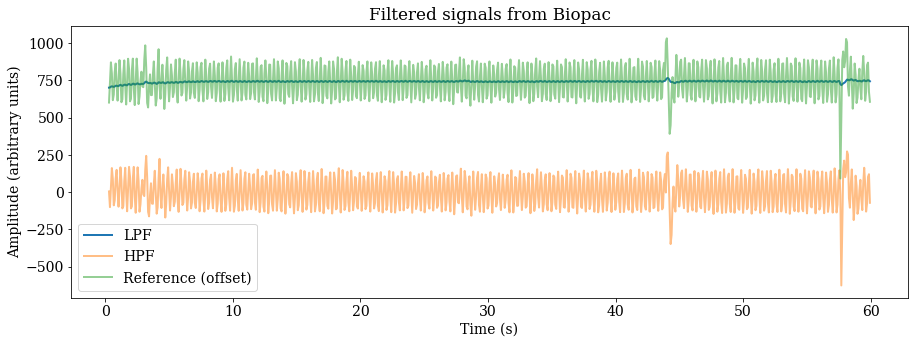

In [43]:
import matplotlib.pyplot as plt

# make a deep copy to ensure that changes to the list will not affect the one obtained from the output
import copy 
series = copy.deepcopy(raw_series)
# Add to the sequence some reference signal
ts = Timeseries("Reference")
ts.data = din.data[1:]
ts.name += " (offset)"
ts.time = din.time[1:]
series[0].append(ts)

# Add some time information based on knowledge of what was input and the expected output
series[0][0].time = ts.time
series[0][1].time = ts.time

series[0][0].data = series[0][0].data

# Generate subplot to show the results
plts = len(series)
plt_height = 5

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 14
FIG_HEIGHT = 4
fig, axs = plt.subplots(ncols=plts, figsize=(3*plt_height*plts, plt_height))

# Plot configurations
a = [1,0.5,0.5] # Alpha (opacity)

# Plot the desired signals
for p in range(plts):
    for s in range(len(series[p])):
        ax = axs if len(series) == 1 else axs[p] 
        if len(series[p][s].time) > 0:
            ax.plot(series[p][s].time, series[p][s].data, 
                    alpha = a[s], linewidth=2)
        else:
            ax.plot(series[p][s].data, 
                    alpha = a[s])
    ax.legend([seq.name for seq in series[p]], loc='lower left')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (arbitrary units)")
    ax.set_title(f"Filtered signals from {FILENAME}")


## Performance and Energy

This will generate a report in `sw/riscv/build/energy_estim.csv`. 

Run the `estim.ipynb` notebook to visualize the results. 

Total cycles: 	0.53 s
Total energy: 	391.81 µJ
Avg power:	737.95 µW
---------------------
❌ Power FAIL
✅ Latency SUCCESS


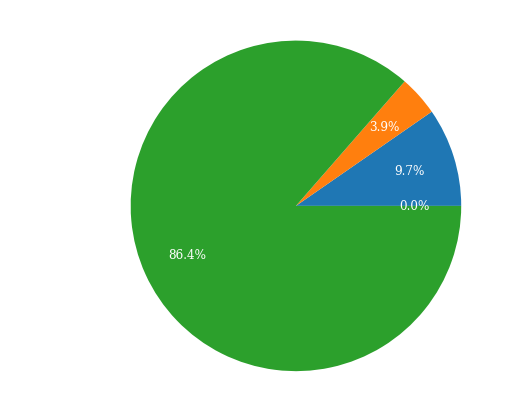

In [44]:
# Define some budgets that we should not cross
POWER_BUDGET_W      = 100e-6
LATENCY_BUDGET_S    = 1

xh.read_perf_cnt(perf_cnt);         # Read the performance counters
xh.estimate_performance(False);     # Estimate the performance 
xh.estimate_energy("HVT", False);   # Estimate the energy

rep_summary, rep_latency, rep_energy  = report() # Get the report

# Check that some contraints are satisfied
print("---------------------")
if rep_summary['Power_W']   < POWER_BUDGET_W:   print("✅ Power SUCCESS")   
else: print("❌ Power FAIL")
if rep_summary['Latency_s'] < LATENCY_BUDGET_S: print("✅ Latency SUCCESS") 
else: print("❌ Latency FAIL")

# Remove modules that will not be used in the design
pruned_energy = remove_module(rep_energy, "always-on peripheral subsystem" )
pruned_energy = remove_module(pruned_energy, "debug ao" )
pruned_energy = remove_module(pruned_energy, "spi" )
pruned_energy = remove_module(pruned_energy, "i2c" )

# Plot a breakdown of the energy consumption
plot_energy( pruned_energy, level=1 )

# In case you want to print the dictionaries containing the breakdown
if 0:
    import pprint
    pprint.pprint(pruned_energy)